# Language Model with LSTM architecture


*   Zihadul Azam
*   Id: 221747
*   zihadul.azam@studenti.unitn.it



## Import Libraries

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, TimeDistributed, Dense
from keras.callbacks import EarlyStopping
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

## Params

In [13]:
epochs = 100
batch_size = 20
seq_size = 35

emb_size = 650
hidden_size = 650
num_layers = 2

dropout_rate = 0.5

## Load Data

### Set data folder path here:

In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
data_path = '/content/drive/MyDrive/nlu-data'
train_path = data_path + '/train.txt'
valid_path = data_path + '/valid.txt'
test_path = data_path + '/test.txt'

In [16]:
# read file and tokenize
def read_file(path):
  result = []
  with open(path, 'r') as file:
    for line in file:
        # add <eos> tag at the end of every sent
        for word in line.split() + ['<eos>']:
          result.append(word)
  return result

In [17]:
# this dictionary maps word to idx
word2int = {'<unk>': 0, '<eos>': 1}

# this is a list of words, maps idx to word
# e.g. int2word[0] will return '<unk>'
int2word = []

def convertWord2Int(word):
  return word2int[word]

def convertInt2Word(int_v):
  return int2word[int_v]

Make vocabulary from a list of words

In [18]:
def make_vocab(word_list):
  # create vocab set
  vocab = set()
  for token in word_list:
    if token != '<unk>' and token != '<eos>':
      vocab.add(token)

  sorted_vocab = sorted(list(vocab))
  for i, v in enumerate(sorted_vocab):
    word2int[v] = len(word2int)
  
  for key, _ in word2int.items():
    int2word.append(key)

In [19]:
def data_loader(path, is_make_vocab=False, batch_size=50, seq_size = 5):
  # read file and tokenize
  words = read_file(path)
  
  # make vocab
  if is_make_vocab:
    make_vocab(words)

  # transform word list to int list
  words_int = [convertWord2Int(w) for w in words]

  # shrink, we drop the last uncompleted batch
  tot_in_batch = batch_size * seq_size 
  cut_size = tot_in_batch * (len(words_int) // (tot_in_batch))
  input =  words_int[:cut_size]

  # target shifted by one pos
  target = np.zeros_like(input)
  target[:-1] = input[1:]

  return input, target

Load Train, Val and Test data from files

In [20]:
train_in, train_tr = data_loader(train_path, is_make_vocab= True, batch_size=batch_size, seq_size=seq_size)
val_in, val_tr = data_loader(valid_path, is_make_vocab=False, batch_size=batch_size, seq_size=seq_size)
test_in, test_tr = data_loader(test_path, is_make_vocab=False, batch_size=batch_size, seq_size=seq_size)

vocab_size = len(int2word)
print('Vocabulary size: ', vocab_size)

Vocabulary size:  10000


Make sequences and batchify

In [21]:
def batchify(data, batch_size, seq_size):
  data = np.array(data)
  data = data.reshape((batch_size, -1))
  k = data.shape[1] // seq_size
  data = np.split(data, k, axis=1)
  data = np.concatenate(data)

  return data

def SeqAndBatch(input, target, batch_size, seq_size):
  input = batchify(input, batch_size, seq_size)
  target = batchify(target, batch_size, seq_size)
  return input, target

In [22]:
train_input, train_target = SeqAndBatch(train_in, train_tr, batch_size, seq_size)
val_input, val_target = SeqAndBatch(val_in, val_tr, batch_size, seq_size)
test_input, test_target = SeqAndBatch(test_in, test_tr, batch_size, seq_size)

print('Input batches: shape',train_input.shape)
print(train_input)
print()
print('Target batches: shape',train_target.shape)
print(train_target)

Input batches: shape (26540, 35)
[[ 237  807  950 ... 9012 1040  609]
 [4748  308  657 ...  317  145 9010]
 [9012 8034 2031 ...  424 3851    0]
 ...
 [2383 9018 4663 ... 6222    1 1291]
 [9012 7368   11 ...    3   45 5667]
 [   1    0   48 ... 5667  971 3772]]

Target batches: shape (26540, 35)
[[ 807  950 1325 ... 1040  609   48]
 [ 308  657 3925 ...  145 9010 9928]
 [8034 2031 9779 ... 3851    0    1]
 ...
 [9018 4663 9119 ...    1 1291 5032]
 [7368   11 7236 ...   45 5667 4465]
 [   0   48    0 ...  971 3772    0]]


## Model

Define perplexity function

In [12]:
def ppl(y_true, y_pred):
  cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
  perplexity = K.exp(K.mean(cross_entropy))
  return perplexity

Create LSTM Model

In [13]:
def create_model(vocab_size, emb_size, hidden_size, batch_size, seq_size, num_layers, dropout_rate):
  model = Sequential()

  #embedding layer
  model.add(Embedding(vocab_size, emb_size, batch_input_shape=(batch_size, seq_size), mask_zero = True))
  model.add(Dropout(dropout_rate))

  # lstm layers
  for i in range(num_layers):
    model.add(LSTM(hidden_size, return_sequences= True))
    model.add(Dropout(dropout_rate))

  # fc layer + softmax
  model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

  return model

In [14]:
model = create_model(vocab_size, emb_size, hidden_size, batch_size, seq_size, num_layers, dropout_rate)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (20, 35, 650)             6500000   
_________________________________________________________________
dropout (Dropout)            (20, 35, 650)             0         
_________________________________________________________________
lstm (LSTM)                  (20, 35, 650)             3382600   
_________________________________________________________________
dropout_1 (Dropout)          (20, 35, 650)             0         
_________________________________________________________________
lstm_1 (LSTM)                (20, 35, 650)             3382600   
_________________________________________________________________
dropout_2 (Dropout)          (20, 35, 650)             0         
_________________________________________________________________
time_distributed (TimeDistri (20, 35, 10000)           6

## Train

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[ppl])
history = model.fit(train_input, train_target, batch_size, epochs, callbacks=[early_stopping], validation_data=(val_input, val_target))

Epoch 1/100
1327/1327 [==============================] - 388s 271ms/step - loss: 6.3864 - ppl: 1080.6881 - val_loss: 5.4683 - val_ppl: 334.2172
Epoch 2/100
1327/1327 [==============================] - 357s 269ms/step - loss: 5.3964 - ppl: 318.1609 - val_loss: 5.1274 - val_ppl: 240.2699
Epoch 3/100
1327/1327 [==============================] - 356s 268ms/step - loss: 5.0645 - ppl: 229.1144 - val_loss: 4.9505 - val_ppl: 202.3024
Epoch 4/100
1327/1327 [==============================] - 354s 267ms/step - loss: 4.8492 - ppl: 186.1401 - val_loss: 4.8411 - val_ppl: 182.4797
Epoch 5/100
1327/1327 [==============================] - 353s 266ms/step - loss: 4.7103 - ppl: 162.6453 - val_loss: 4.7651 - val_ppl: 169.9805
Epoch 6/100
1327/1327 [==============================] - 351s 264ms/step - loss: 4.5883 - ppl: 144.3916 - val_loss: 4.7202 - val_ppl: 162.9679
Epoch 7/100
1327/1327 [==============================] - 349s 263ms/step - loss: 4.4857 - ppl: 130.5288 - val_loss: 4.6904 - val_ppl: 158.893

### Show Plots

dict_keys(['loss', 'ppl', 'val_loss', 'val_ppl'])


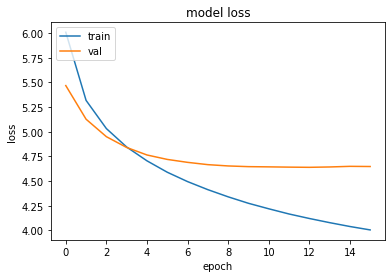

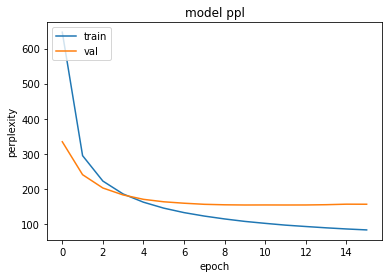

In [17]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# summarize history for ppl
plt.plot(history.history['ppl'])
plt.plot(history.history['val_ppl'])
plt.title('model ppl')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test

In [19]:
# test after training
test_loss = model.evaluate(test_input, test_target, batch_size)
# calculate ppl of the test
test_ppl = K.exp(test_loss[0])

print('Test loss: {0}'.format(test_loss[0]))
print('Test perplexity: {0}'.format(test_ppl))

117/117 [==============================] - 6s 55ms/step - loss: 4.5115 - ppl: 146.0111
Test loss: 4.511485576629639
Test perplexity: 91.05699157714844


## Experiments
I have tried different configurations by changing embedding size and hidden size. Here are the results:

Embedding size  | Hidden size | Early stopped (epoch) | Test loss | Test PPL 
----------------|-------------|-----------------------|-----------|---------
350             |350          | 28                    |4.533      |93.064
500             |500          | 20                    |4.532      |92.988
650             |650          | 16                    |4.512      |91.057

---
